# Pneumonia Segmentation Project

This notebook shows an automated pipeline for pixel-level classification.

* For the sake of this example, no files are logged or saved.

In [1]:
import sys
sys.path.append("/home/brandon/tfcaidm-pkg")

import numpy as np
import pandas as pd
import tensorflow as tf

from jarvis.train import params
from jarvis.utils.general import gpus, overload

from tfcaidm import Jobs
from tfcaidm import JClient
from tfcaidm import Dataset
from tfcaidm import Model
from tfcaidm import Trainer

**Autoselect GPU (use only on caidm cluster)**

In [2]:
gpus.autoselect()

[ 2021-11-17 16:11:35 ] CUDA_VISIBLE_DEVICES automatically set to: 1           


## Define experiment

---

**Purpose**

Compare the performance of different convolutional models for `supervised semantic segmentation`.

**Details**

* `Dataset`: Xray scans of the chest from [RSNA](https://www.rsna.org/education/ai-resources-and-training/ai-image-challenge/rsna-pneumonia-detection-challenge-2018), positive casess: 500, negative cases: 500, total: 1000
* `Model`: Different UNet family architectures.
* `Training`: A weighted loss is applied to mask areas outside of the lungs and apply higher weights to areas that contain pneumonia.
    * The model is trained on a 80/20 train/validation split, 1000 total scans, 800 scans for training, 200 scans for validation.
* `Metric`: Dice score is used for regions of predicted segmentations within the lung.

**Challenges**

* There is a very `limited amount of annotated data` (800 samples for training).
* The ground-truth annotations of pneumonia are made in the shape of an `ellipse which is not an ideal source of ground-truth`, but it is ground-truth nonetheless.

**Results**

Coming soon...

---

### Get hyperparameters

In [3]:
# --- Get hyperparameters
runs = Jobs(path="../../../configs/ymls/xr_pna/pipeline.yml")

# --- Hyperparameters for N runs
all_hyperparams = runs.get_params()

# ---- Hyperparameters for first run
hyperparams = all_hyperparams[0]

In [4]:
pd.DataFrame(hyperparams).iloc[0]

env/path/client                   /home/brandon/tfcaidm-pkg/configs/ymls/xr_pna/...
model/model                                                                unet
model/conv_type                                                            conv
model/pool_type                                                            conv
model/eblock                                                               conv
model/elayer                                                                  1
model/dblock                                                               conv
model/depth                                                                   4
model/width                                                                  32
model/width_scaling                                                           1
model/kernel_size                                                             3
model/strides                                                                 2
model/bneck                         

### Dataset

In [20]:
client = Dataset(hyperparams).get_client(0)
gen_train, gen_valid = client.create_generators(test=True)

#### Dataset statistics

This is usually done at the very beginning of every data science project.

In [21]:
client.dataset_size(fold=0)

{'train': '800', 'valid': '200'}

In [22]:
train_0 = client.db.header["valid"] != 0
valid_0 = client.db.header["valid"] == 0

trainset_0 = client.db.header[train_0]
validset_0 = client.db.header[valid_0]

In [23]:
trainset_0

,class,area,cohort-neg,cohort-pna,valid
sid,,,,,
000924cf-0f8d-42bd-9158-1af53881a557,0,,True,False,2
0010f549-b242-4e94-87a8-57d79de215fc,0,,True,False,3
0022995a-45eb-4cfa-9a59-cd15f5196c64,0,,True,False,4
0025d2de-bd78-4d36-9f72-e15a5e22ca82,0,,True,False,1
002c591d-df62-4e34-8eda-838c664430a9,0,,True,False,1
...,...,...,...,...,...
15d9403c-bf5b-41be-add6-a5c2a9e16d35,2,,False,True,2
15df7a1f-a2a4-4d5e-8771-3280fa1184c3,2,,False,True,1
15ea3d73-122d-4273-83e0-01f62d801ca7,2,,False,True,3


In [24]:
validset_0

,class,area,cohort-neg,cohort-pna,valid
sid,,,,,
00293de0-a530-41dc-9621-0b3def01d06d,0,,True,False,0
00f2de16-a231-40c3-9a5f-8198f530a4b0,0,,True,False,0
01027bc3-dc40-4165-a6c3-d6be2cb7ca34,0,,True,False,0
01aad2a6-3b93-45e3-bf37-2d73348cb6fc,0,,True,False,0
01f0f4bf-e678-430e-b43d-2968e2c4976c,0,,True,False,0
...,...,...,...,...,...
15de0e36-aad2-49f5-b797-dba25cc0c500,2,,False,True,0
160786ef-dd0f-4c51-8268-b6faa3cfe59b,2,,False,True,0
160d4148-6c88-47fb-ad49-b4965eb8a931,2,,False,True,0


#### Dataset viz

In [14]:
from jarvis.utils.display import imshow

* `xs["dat"]`: image of the chest (input to model)
* `xs["msk"]`: mask of the lungs (applied to loss during training)
* `xs["pna"]`: area containing Pneumonia (what model needs to predict)

**Note:** `xs["pna"]` is an ellipse which is not an ideal source of ground-truth, but it is ground-truth nonetheless.

##### Negative example

In [15]:
while True:
    xs, ys = next(gen_train)
    if 0 in list(np.unique(xs["pna"])):
        break

[ 2021-11-17 13:15:22 ] [>...................] 0.125% : Iterating | 000001      

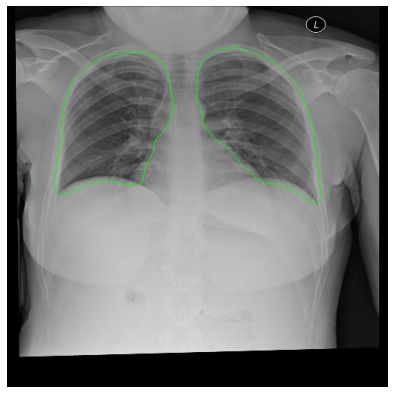

In [16]:
imshow(xs["dat"], xs["msk"])

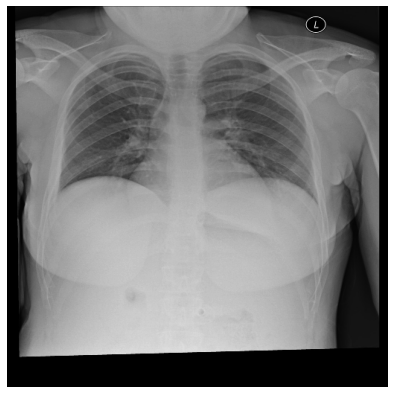

In [17]:
imshow(xs["dat"], xs["pna"])

##### Positive example

In [13]:
while True:
    xs, ys = next(gen_train)
    if 1 in list(np.unique(xs["pna"])):
        break

[ 2021-11-13 21:25:24 ] [==========>.........] 50.625% : Iterating | 000405     

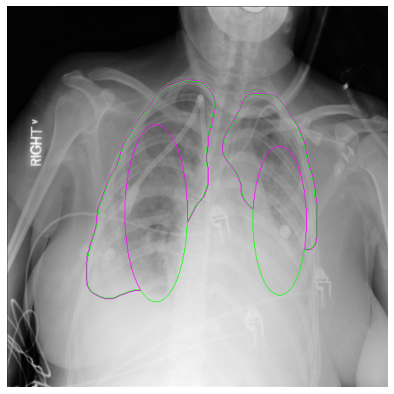

In [14]:
imshow(xs["dat"], xs["msk"])

### Train model

In [39]:
def train(hyperparams, fold=0):
    client = Dataset(hyperparams).get_client(fold)
    gen_train, gen_valid = client.create_generators(test=False)

    model = Model(client).create()

    trainer = Trainer(hyperparams)
    results = trainer.fit(model, gen_train, gen_valid, callbacks=None)
    
    return results

In [41]:
results = []

for hyperparams in all_hyperparams:
    results.append(train(hyperparams))

(None, 1, 512, 512, 32)
(None, 1, 256, 256, 32)
(None, 1, 128, 128, 32)
(None, 1, 64, 64, 32)
(None, 1, 32, 32, 32)
(None, 1, 64, 64, 32)
(None, 1, 128, 128, 32)
(None, 1, 256, 256, 32)
(None, 1, 512, 512, 32)
Epoch 1/10
100/100 [==============================] - 157s 1s/step - loss: 0.3528 - dice_1: 0.1892
Epoch 2/10
100/100 [==============================] - 150s 2s/step - loss: 0.3322 - dice_1: 0.3050
Epoch 3/10
100/100 [==============================] - 151s 2s/step - loss: 0.2703 - dice_1: 0.5114
Epoch 4/10
100/100 [==============================] - 151s 2s/step - loss: 0.2830 - dice_1: 0.5084
Epoch 5/10
100/100 [==============================] - 205s 2s/step - loss: 0.2661 - dice_1: 0.5228 - val_loss: 5.1983 - val_dice_1: 0.3450
Epoch 6/10
100/100 [==============================] - 151s 2s/step - loss: 0.2658 - dice_1: 0.5044
Epoch 7/10
100/100 [==============================] - 151s 2s/step - loss: 0.2738 - dice_1: 0.4940
Epoch 8/10
100/100 [==============================] - 151

---

Best learning rate is between 1e-3 and 1e-4, probably 3e-4 is good.

**Eval**

In [33]:
from tfcaidm.models import audit

In [34]:
client = Dataset(hyperparams).get_client(fold=0)
gen_train, gen_valid = client.create_generators(test=True)

In [35]:
true = []
mask = []
pred1 = []
pred2 = []
pred3 = []
pred4 = []
pred5 = []

clf1 = audit.Classifier(results[0])
clf2 = audit.Classifier(results[1])
clf3 = audit.Classifier(results[2])
clf4 = audit.Classifier(results[3])
clf5 = audit.Classifier(results[4])

for xs, ys in gen_valid:
    true.append(xs["pna"])
    mask.append(xs["msk"])
    
    pred1.append(clf1.model(xs)["pna/logits"])
    pred2.append(clf2.model(xs)["pna/logits"])
    pred3.append(clf3.model(xs)["pna/logits"])
    pred4.append(clf4.model(xs)["pna/logits"])
    pred5.append(clf5.model(xs)["pna/logits"])
    
    
true = np.array(true)
mask = np.array(mask)
pred1 = np.array(pred1)
pred2 = np.array(pred2)
pred3 = np.array(pred3)
pred4 = np.array(pred4)
pred5 = np.array(pred5)

[ 2021-11-17 16:24:46 ] [====================] 100.000% : Iterating | 000200    

**Viz**

In [36]:
from jarvis.utils.display import imshow

In [168]:
ind = 150

array([0, 1], dtype=uint8)

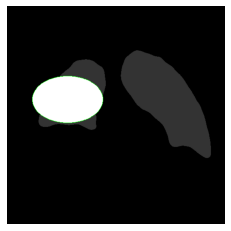

In [175]:
imshow(mask[ind], true[ind], figsize=(4, 4))
np.unique(true[ind])

**Observations**

* When no pneumonia, model is predicting pneumonia outside of the lungs, this is a given based on the masked loss.
* Small learning rate makes the predictions appear less confident (more noisy)
* Low precision = lot's of false positives (pneumonia when really no pneumonia)
* Low recall = lots' of false negatives (no pneumonia when really have pneumonia)

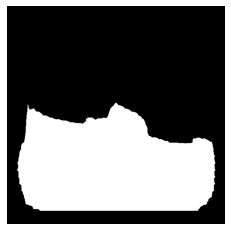

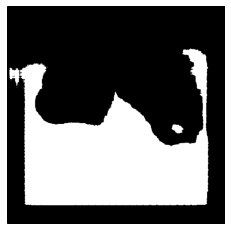

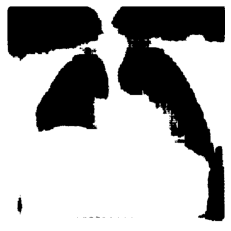

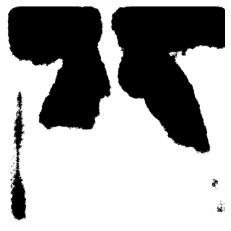

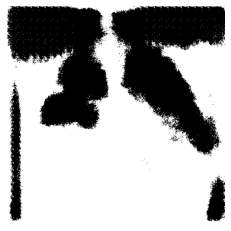

In [170]:
# --- No mask

imshow(np.argmax(pred1[ind], axis=-1)[..., None], figsize=(4, 4))
imshow(np.argmax(pred2[ind], axis=-1)[..., None], figsize=(4, 4))
imshow(np.argmax(pred3[ind], axis=-1)[..., None], figsize=(4, 4))
imshow(np.argmax(pred4[ind], axis=-1)[..., None], figsize=(4, 4))
imshow(np.argmax(pred5[ind], axis=-1)[..., None], figsize=(4, 4))

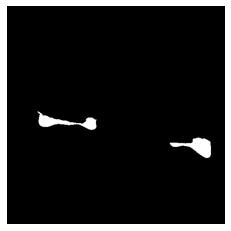

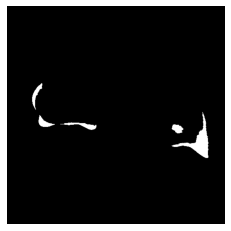

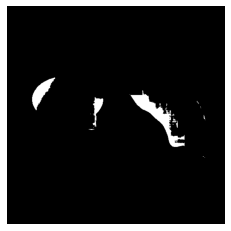

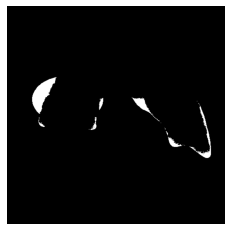

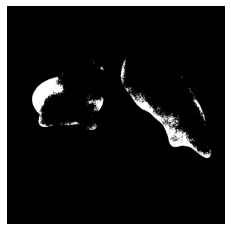

In [172]:
# --- Mask

imshow(np.argmax(pred1[ind], axis=-1)[..., None] * (mask[ind] > 0), figsize=(4, 4))
imshow(np.argmax(pred2[ind], axis=-1)[..., None] * (mask[ind] > 0), figsize=(4, 4))
imshow(np.argmax(pred3[ind], axis=-1)[..., None] * (mask[ind] > 0), figsize=(4, 4))
imshow(np.argmax(pred4[ind], axis=-1)[..., None] * (mask[ind] > 0), figsize=(4, 4))
imshow(np.argmax(pred5[ind], axis=-1)[..., None] * (mask[ind] > 0), figsize=(4, 4))

`1e-1`

In [182]:
%%time

print(clf1.classification_report(true, np.argmax(pred1, axis=-1)[..., None]))
print(clf1.classification_report(true, np.argmax(pred1, axis=-1)[..., None] * (mask > 0)))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84  49632838
           1       0.10      0.52      0.17   2795962

    accuracy                           0.73  52428800
   macro avg       0.53      0.63      0.50  52428800
weighted avg       0.92      0.73      0.80  52428800

              precision    recall  f1-score   support

           0       0.97      0.98      0.98  49632838
           1       0.60      0.52      0.56   2795962

    accuracy                           0.96  52428800
   macro avg       0.79      0.75      0.77  52428800
weighted avg       0.95      0.96      0.95  52428800

CPU times: user 2min 53s, sys: 6.12 s, total: 2min 59s
Wall time: 2min 59s


`1e-2`

In [183]:
%%time

print(clf1.classification_report(true, np.argmax(pred2, axis=-1)[..., None]))
print(clf1.classification_report(true, np.argmax(pred2, axis=-1)[..., None] * (mask > 0)))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82  49632838
           1       0.12      0.70      0.20   2795962

    accuracy                           0.70  52428800
   macro avg       0.55      0.70      0.51  52428800
weighted avg       0.93      0.70      0.79  52428800

              precision    recall  f1-score   support

           0       0.98      0.96      0.97  49632838
           1       0.52      0.70      0.59   2795962

    accuracy                           0.95  52428800
   macro avg       0.75      0.83      0.78  52428800
weighted avg       0.96      0.95      0.95  52428800

CPU times: user 2min 52s, sys: 5.44 s, total: 2min 58s
Wall time: 2min 58s


`1e-3`

In [184]:
%%time

print(clf1.classification_report(true, np.argmax(pred3, axis=-1)[..., None]))
print(clf1.classification_report(true, np.argmax(pred3, axis=-1)[..., None] * (mask > 0)))

              precision    recall  f1-score   support

           0       0.98      0.50      0.66  49632838
           1       0.08      0.80      0.15   2795962

    accuracy                           0.52  52428800
   macro avg       0.53      0.65      0.41  52428800
weighted avg       0.93      0.52      0.64  52428800

              precision    recall  f1-score   support

           0       0.99      0.96      0.97  49632838
           1       0.51      0.80      0.63   2795962

    accuracy                           0.95  52428800
   macro avg       0.75      0.88      0.80  52428800
weighted avg       0.96      0.95      0.95  52428800

CPU times: user 2min 53s, sys: 5.88 s, total: 2min 59s
Wall time: 2min 59s


`1e-4`

In [185]:
%%time

print(clf1.classification_report(true, np.argmax(pred4, axis=-1)[..., None]))
print(clf1.classification_report(true, np.argmax(pred4, axis=-1)[..., None] * (mask > 0)))

              precision    recall  f1-score   support

           0       0.98      0.48      0.64  49632838
           1       0.08      0.82      0.15   2795962

    accuracy                           0.49  52428800
   macro avg       0.53      0.65      0.39  52428800
weighted avg       0.93      0.49      0.61  52428800

              precision    recall  f1-score   support

           0       0.99      0.95      0.97  49632838
           1       0.51      0.82      0.63   2795962

    accuracy                           0.95  52428800
   macro avg       0.75      0.89      0.80  52428800
weighted avg       0.96      0.95      0.95  52428800

CPU times: user 2min 53s, sys: 6.6 s, total: 3min
Wall time: 3min


`1e-5`

In [186]:
%%time

print(clf1.classification_report(true, np.argmax(pred5, axis=-1)[..., None]))
print(clf1.classification_report(true, np.argmax(pred5, axis=-1)[..., None] * (mask > 0)))

              precision    recall  f1-score   support

           0       0.98      0.48      0.65  49632838
           1       0.08      0.83      0.15   2795962

    accuracy                           0.50  52428800
   macro avg       0.53      0.65      0.40  52428800
weighted avg       0.93      0.50      0.62  52428800

              precision    recall  f1-score   support

           0       0.99      0.95      0.97  49632838
           1       0.47      0.83      0.60   2795962

    accuracy                           0.94  52428800
   macro avg       0.73      0.89      0.79  52428800
weighted avg       0.96      0.94      0.95  52428800

CPU times: user 2min 55s, sys: 4.63 s, total: 3min
Wall time: 3min


**Save**

In [97]:
# clf1.model.save("models/clf1")
# clf2.model.save("models/clf2")
# clf3.model.save("models/clf3")
# clf4.model.save("models/clf4")
# clf5.model.save("models/clf5")

INFO:tensorflow:Assets written to: models/clf1/assets
INFO:tensorflow:Assets written to: models/clf2/assets
INFO:tensorflow:Assets written to: models/clf3/assets
INFO:tensorflow:Assets written to: models/clf4/assets
INFO:tensorflow:Assets written to: models/clf5/assets


**Load**

In [7]:
from tensorflow.keras import models as TFmodels

In [8]:
# results = []

# results.append(
#     TFmodels.load_model(
#         filepath="models/clf1",
#         compile=False,
#         custom_objects={},
#     )
# )

# results.append(
#     TFmodels.load_model(
#         filepath="models/clf2",
#         compile=False,
#         custom_objects={},
#     )
# )

# results.append(
#     TFmodels.load_model(
#         filepath="models/clf3",
#         compile=False,
#         custom_objects={},
#     )
# )

# results.append(
#     TFmodels.load_model(
#         filepath="models/clf4",
#         compile=False,
#         custom_objects={},
#     )
# )

# results.append(
#     TFmodels.load_model(
#         filepath="models/clf5",
#         compile=False,
#         custom_objects={},
#     )
# )